#### Post-Translational Modifications and Corresponding Amino Acids

1. **Acetylation**:
2. **ADP-ribosylation**:
3. **Amidation**:
4. **AMPylation**:
5. **Biotinylation**: 
6. **Blocked amino end**: 
7. **Butyrylation**: 
8. **C-linked Glycosylation**: 
9. **Carbamidation**: 
10. **Carboxyethylation**: 
11. **Carboxylation**: 
12. **Cholesterol ester**: 
13. **Citrullination**: 
14. **Crotonylation**: 
15. **D-glucuronoylation**: 
16. **Deamidation**: 
17. **Deamination**: 
18. **Decanoylation**: 
19. **Decarboxylation**: 
20. **Dephosphorylation**: 
21. **Disulfide bond**: 
22. **Farnesylation**: 
23. **Formation of an isopeptide bond**: 
24. **Formylation**: 
25. **Gamma-carboxyglutamic acid**: 
26. **Geranylgeranylation**: 
27. **Glutarylation**: 
28. **Glutathionylation**: 
29. **GPI-anchor**: 
30. **Hydroxyceramide ester**: 
31. **Hydroxylation**: 
32. **Iodination**: 
33. **Lactoylation**: 
34. **Lactylation**: 
35. **Lipoylation**: 
36. **Malonylation**: 
37. **Methylation**: 
38. **Myristoylation**: 
39. **N-carbamoylation**: 
40. **N-linked Glycosylation**: 
41. **N-palmitoylation**: 
42. **Neddylation**: 
43. **Nitration**: 
44. **O-linked Glycosylation**: 
45. **O-palmitoleoylation**: 
46. **O-palmitoylation**: 
47. **Octanoylation**: 
48. **Oxidation**: 
49. **Phosphatidylethanolamine amidation**: 
50. **Phosphorylation**: 
51. **Propionylation**: 
52. **Pyrrolidone carboxylic acid**: 
53. **Pyrrolylation**: 
54. **Pyruvate**: 
55. **S-archaeol**: 
56. **S-carbamoylation**: 
57. **S-Cyanation**: 
58. **S-cysteinylation**: 
59. **S-diacylglycerol**: 
60. **S-linked Glycosylation**: 
61. **S-nitrosylation**: 
62. **S-palmitoylation**: 
63. **Serotonylation**: 
64. **Stearoylation**: 
65. **Succinylation**: 
66. **Sulfation**: 
67. **Sulfhydration**: 
68. **Sulfoxidation**: 
69. **Sumoylation**: 
70. **Thiocarboxylation**: 
71. **Ubiquitination**: 
72. **UMPylation**: 



In [6]:
from glob import glob

AA = "A C D E F G H I K L M N P Q R S T V W Y".split(' ')
filepaths = [i.replace('\\', '/') for i in glob('rawDataset/*')]
filepaths.remove('rawDataset/zips')

In [7]:
# But before we add them, we NEED to construct subsequences.
# This is the heuristic:
# Suppose we have a protein sequence MKGLGTDEDSLIEIICSRTNQELQEINRVYKEMYKTDLEKDIISDTSGDFRKLMVALAK
# Suppose that PTM occurs at site 22, which is amino acid E
# Then we pick 10 upstream and 10 downstream amino acids
#   to construct our subsequence (that subsequence then becomes IEIICSRTNQELQEINRVYKE)
# Now say that PTM occurs at site 4, which is amino acid L
# Then since we don't have information of 6 amino acids downstream (left of site),
#   we prepend it with a hyphen (-)
# This is similar for when we don't have information of N amino acids upstream (right of site)

# Now we need to devise an algorithm for this heuristic.

def construct_subsequence(protein: str, site: int, no_stream_aa: int = 10):
    # Treat PTM site as 0-based (so subtract 1 for convenience)
    start = max(0, site - no_stream_aa)
    end = min(len(protein), site + no_stream_aa + 1)

    subsequence: str = protein[start:end]

    if site < no_stream_aa:
        subsequence = ('-' * (no_stream_aa - site)) + subsequence 
    if site + no_stream_aa > len(protein):
        subsequence += ('-' * ((site + no_stream_aa + 1) - len(protein)))
    
    return subsequence


In [8]:
import pandas as pd
import math
import typing
import matplotlib.pyplot as plt
import requests

def log_odds(sequences: dict) -> dict[dict[str, float]]:
    table = dict.fromkeys(sequences, 0)

    for position, sequence in sequences.items():
        log_odds_table = dict.fromkeys(AA, 0)
        for aa in AA:
            total = len(sequence)
            count = sequence.count(aa)
            log_odds_table[aa] = count / total

        table[position] = log_odds_table

    return log_odds_table

def preprocess(filepath: str):
    df = pd.read_csv(
        filepath,
        names=[
            'ProID',
            'Acc#',
            'ModSite',
            'PTM',
            'EvdId',
            'Seq'
        ],
        header=None,
        sep='\t'
    )

    na_df = df[df['Seq'].isna()]
    if len(na_df):
        print("For file", filepath.split('/')[-1])
        accession_numbers = na_df['Acc#'].unique().tolist()
        for accession_number in accession_numbers:
            got_response = True
            got_sequence = True
            while got_response:
                try:
                    got_response = False
                    response = requests.get(
                        f'http://www.ebi.ac.uk/proteins/api/proteins/{accession_number}'
                    )
                    print(f"\tGot response for {accession_number}.")
                except:
                    got_response = True
                try:
                    sequence = response.json()['sequence']['sequence']
                except:
                    got_sequence = False
                    sequence = ''
                    print("No sequence found for", accession_number)
            positions = na_df[na_df['Acc#'] == accession_number].ModSite.to_list()
            for position in positions:
                if got_sequence:
                    subsequence = construct_subsequence(sequence, position-1)
                else:
                    subsequence = ''
                df.loc[(df['Acc#'] == accession_number) & (df['ModSite'] == position), 'Seq'] = subsequence

        df.to_csv(f"{filepath}.csv", index=False)
        # obj = dict(zip(accession_numbers, sequences))
        # import json
        # with open(f"sequences/{filepath.split('/')[-1]}.json", 'w') as f:
        #     json.dump(obj, f, indent=4)
    else:
        df.to_csv(f"{filepath}.csv", index=False)
        print("Clear for", filepath.split('/')[-1])

def construct_table(filepath: str):
    df = pd.read_csv(
        filepath,
        names=[
            'ProID',
            'Acc#',
            'ModSite',
            'PTM',
            'EvdId',
            'Seq'
        ],
        header=None,
        sep='\t'
    )

    seqs = df['Seq']
    seqs = seqs.to_list()
    

    transposed = list(map(''.join, zip(*seqs)))
    pos = [f"+{i}" if i > 0 else f"{i}" for i in range(-10, 11)]
    table = {i: seq for i, seq in zip(pos, transposed)}
    log_odds_table = log_odds(table)
        
    table_df = pd.DataFrame(log_odds_table)

    _, ax = plt.subplots(figsize=(8, 4))

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    header_color = '#4B8BBE'
    row_colors = ['#f0f0f0', '#ffffff']

    table = ax.table(
        cellText=table_df.round(2).values,
        colLabels=table_df.columns,
        rowLabels=table_df.index,
        loc='center',
        cellLoc='center',
        colColours=[header_color] * len(table_df.columns),
        rowColours=row_colors * (len(table_df) // 2 + 1)
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(table_df.columns))))

    for (i, j), cell in table.get_celld().items():
        if i == -1 or j == -1:
            cell.set_fontsize(12)
            cell.set_text_props(weight='bold', color='white')
            cell.set_edgecolor('black')
            cell.set_facecolor(header_color)
        else:
            cell.set_edgecolor('gray')
            if i % 2 == 0:
                cell.set_facecolor(row_colors[0])
            else:
                cell.set_facecolor(row_colors[1])


    ax.set_title(
        'Log-odd probabilities of amino acids for ADP-ribosylation',
        pad=20,
        fontsize=14,
        weight='bold',
        color='#34495E'
    )

    filename = filepath.split('/')[-1]

    plt.tight_layout()
    plt.savefig(
        f'rawDataset/tables/{filename}.png',
        bbox_inches='tight',
        dpi=300
    )

    plt.show()

In [6]:
# Round 1
for filepath in filepaths:
    preprocess(filepath)

For file Acetylation
	Got response for Q6IPS9.
	Got response for Q8S9M1-3.
	Got response for Q8S9M1-4.
	Got response for Q8S9M1-5.
	Got response for P9WPF7-2.
	Got response for Q14155-1.
	Got response for Q14155-6.
	Got response for Q38929-2.
	Got response for Q8WWW0-2.
	Got response for P08195-2.
	Got response for Q01976-2.
	Got response for P49419-2.
	Got response for Q5JPI3-2.
	Got response for A8MS41-3.
	Got response for F4HYF3-2.
	Got response for P04819-2.
	Got response for P41921-2.
	Got response for Q6YP21-3.
	Got response for P61244-2.
	Got response for P53604-2.
	Got response for P02602-2.
	Got response for P32831-2.
	Got response for Q94AF2-2.
	Got response for P32961-2.
	Got response for P49023-4.
	Got response for P98175-5.
	Got response for O13563-2.
	Got response for Q16851-2.
	Got response for P31946-2.
	Got response for P68251-2.
	Got response for Q28055-2.
	Got response for Q9UBL3-2.
	Got response for Q9UBL3-3.
	Got response for O75061-3.
	Got response for O75061-4.
	

In [8]:
df = pd.read_csv(
    r'rawDataset\Acetylation',
    names=[
        'ProID',
        'Acc#',
        'ModSite',
        'PTM',
        'EvdId',
        'Seq'
    ],
    header=None,
    sep='\t'
)

In [9]:
df[df['Acc#'] == 'O14746'].ModSite.to_list()

[1059]

In [70]:
# Round 2
import json
from glob import glob
import requests

def preprocess_again(filepath: str):
    df = pd.read_csv(
        f"{filepath}"
    )

    na_df = df[df['Seq'].isna()]

    if len(na_df):
        print("Doing for", filepath.split('/')[-1])
        accession_numbers = na_df['Acc#'].unique().tolist()
        for accession_number in accession_numbers:
            got_response = True
            while got_response:
                try:
                    got_response = False
                    response = requests.get(
                        f'https://rest.uniprot.org/uniprotkb/{accession_number}',
                        headers={
                            'Accept': 'application/json'
                        }
                    )
                    print("\tGot response for", accession_number)
                except Exception as e:
                    got_response = True
            got_sequence = True
            try:
                response: dict = response.json()
                if 'inactiveReason' in response.keys():
                    if response['inactiveReason']['inactiveReasonType'] == 'DELETED':
                        print("\tWas deleted")
                        uniparc_id = response['extraAttributes']['uniParcId']
                        print(uniparc_id)
                        got_response = True
                        while got_response:
                            try:
                                got_response = False
                                response: dict = requests.get(
                                    f'https://rest.uniprot.org/uniparc/{uniparc_id}',
                                    headers={
                                        'Accept': 'application/json'
                                    }
                                )
                            except Exception as e:
                                got_response = True
                    elif response['inactiveReason']['inactiveReasonType'] == 'DEMERGED':    
                        print("\tWas merged")
                        new_accession_number = response['inactiveReason']['mergeDemergeTo'][0]
                        print(new_accession_number)
                        got_response = True
                        while got_response:
                            try:
                                got_response = False
                                response: dict = requests.get(
                                    f'https://rest.uniprot.org/uniprotkb/{new_accession_number}',
                                    headers={
                                        'Accept': 'application/json'
                                    }
                                )
                            except Exception as e:
                                got_response = True
                    print("Retrieved check")
                    print(response.json()['sequence']['value'])
                    print("Clearance check")
                    sequence = response.json()['sequence']['value']
                else:
                    sequence = response['sequence']['value']
            except Exception as e:
                sequence = ''
                got_sequence = False
                print("\t\tNo sequence found for", accession_number)
                
            positions = na_df[na_df['Acc#'] == accession_number].ModSite.to_list()
            for position in positions:
                if got_sequence:
                    subsequence = construct_subsequence(sequence, position-1)
                else:
                    subsequence = ''
                df.loc[(df['Acc#'] == accession_number) & (df['ModSite'] == position), 'Seq'] = subsequence
        df.to_csv(f"{filepath}_2.csv", index=False)
        
        return 1
    else:
        print("Nothing for", filepath.split('/')[-1])
        return 0


In [22]:
second_filepaths = [i.replace('\\', '/') for i in glob('rawDataset/*.csv')]
for filepath in second_filepaths:
    preprocess_again(filepath)

Nothing for Acetylation.csv
Nothing for ADP-ribosylation.csv
Nothing for Amidation.csv
Nothing for AMPylation.csv
Nothing for Biotinylation.csv
Nothing for Blocked amino end.csv
Nothing for Butyrylation.csv
Nothing for C-linked Glycosylation.csv
Nothing for Carbamidation.csv
Nothing for Carboxyethylation.csv
Nothing for Carboxylation.csv
Nothing for Cholesterol ester.csv
Nothing for Citrullination.csv
Nothing for Crotonylation.csv
Nothing for D-glucuronoylation.csv
Nothing for Deamidation.csv
Nothing for Deamination.csv
Nothing for Decanoylation.csv
Nothing for Decarboxylation.csv
Nothing for Dephosphorylation.csv
Nothing for Disulfide bond.csv
Nothing for Farnesylation.csv
Nothing for Formation of an isopeptide bond.csv
Nothing for Formylation.csv
Nothing for Gamma-carboxyglutamic acid.csv
Nothing for Geranylgeranylation.csv
Nothing for Glutarylation.csv
Nothing for Glutathionylation.csv
Nothing for GPI-anchor.csv
Nothing for Hydroxyceramide ester.csv
Nothing for Hydroxylation.csv
Not

In [10]:
import pandas as pd
import json

def fill_out_gaps(data_filepath: str, protein_filepath: str):
    # We'll just load both files and transfer contents of one file into another to combine
    df = pd.read_csv(
        data_filepath,
        names=[
            'ProID',
            'Acc#',
            'ModSite',
            'PTM',
            'EvdId',
            'Seq'
        ],
        header=None,
        sep='\t'
    )
    
    with open(protein_filepath, 'r') as f:
        content: dict = json.load(f)
    
    for accession_number in content.keys():
        df.loc[df['Acc#'] == accession_number, 'Seq'] = content[accession_number]
    
    df.to_csv(f"{data_filepath}.csv", index=False)

In [7]:
from glob import glob
filepaths = [i.replace('\\', '/') for i in glob('rawDataset2025/*.csv')]

In [8]:
# But before we add them, we NEED to construct subsequences.
# This is the heuristic:
# Suppose we have a protein sequence MKGLGTDEDSLIEIICSRTNQELQEINRVYKEMYKTDLEKDIISDTSGDFRKLMVALAK
# Suppose that PTM occurs at site 22, which is amino acid E
# Then we pick 10 upstream and 10 downstream amino acids
#   to construct our subsequence (that subsequence then becomes IEIICSRTNQELQEINRVYKE)
# Now say that PTM occurs at site 4, which is amino acid L
# Then since we don't have information of 6 amino acids downstream (left of site),
#   we prepend it with a hyphen (-)
# This is similar for when we don't have information of N amino acids upstream (right of site)

# Now we need to devise an algorithm for this heuristic.

import pandas as pd
import requests

def construct_subsequence(protein: str, site: int, no_stream_aa: int = 10):
    # Treat PTM site as 0-based (so subtract 1 for convenience)
    start = max(0, site - no_stream_aa)
    end = min(len(protein), site + no_stream_aa + 1)

    subsequence: str = protein[start:end]

    if site < no_stream_aa:
        subsequence = ('-' * (no_stream_aa - site)) + subsequence 
    if site + no_stream_aa > len(protein):
        subsequence += ('-' * ((site + no_stream_aa + 1) - len(protein)))
    
    return subsequence


In [9]:
# Final preprocessing step - to ensure ALL sequence windows are of length 21
for file in filepaths:
    new_file = file.split('.')[0]
    df = pd.read_csv(file)
    invalid_sequence_df = df[df['Seq'].str.len() != 21]
    if len(invalid_sequence_df):
        print("For", file.split('/')[-1].split('.')[0])
        accessions = invalid_sequence_df["Acc#"].unique()
        for accession_number in accessions:
            got_response = True
            got_sequence = True
            while got_response:
                try:
                    got_response = False
                    response = requests.get(
                        f'http://www.ebi.ac.uk/proteins/api/proteins/{accession_number}'
                    )
                    print(f"\tGot response for {accession_number}.")
                except:
                    got_response = True
                try:
                    sequence = response.json()['sequence']['sequence']
                except:
                    got_response = True
                    while got_response:
                        try:
                            got_response = False
                            response = requests.get(
                                f'https://rest.uniprot.org/uniprotkb/{accession_number}',
                                headers={
                                    'Accept': 'application/json'
                                }
                            )
                            print("\tGot response for", accession_number)
                        except Exception as e:
                            got_response = True
                    got_sequence = True
                    try:
                        response: dict = response.json()
                        if 'inactiveReason' in response.keys():
                            if response['inactiveReason']['inactiveReasonType'] == 'DELETED':
                                print("\tWas deleted")
                                uniparc_id = response['extraAttributes']['uniParcId']
                                got_response = True
                                while got_response:
                                    try:
                                        got_response = False
                                        response: dict = requests.get(
                                            f'https://rest.uniprot.org/uniparc/{uniparc_id}',
                                            headers={
                                                'Accept': 'application/json'
                                            }
                                        )
                                    except Exception as e:
                                        got_response = True
                            elif response['inactiveReason']['inactiveReasonType'] == 'DEMERGED':    
                                print("\tWas merged")
                                accession_number = response['inactiveReason']['mergeDemergeTo'][0]
                                got_response = True
                                while got_response:
                                    try:
                                        got_response = False
                                        response: dict = requests.get(
                                            f'https://rest.uniprot.org/uniprotkb/{accession_number}',
                                            headers={
                                                'Accept': 'application/json'
                                            }
                                        )
                                    except Exception as e:
                                        got_response = True
                            sequence = response.json()['sequence']['value']
                        else:
                            sequence = response['sequence']['value']
                    except Exception as e:
                        sequence = ''
                        got_sequence = False
                        print("\t\tNo sequence found for", accession_number)
            positions = invalid_sequence_df[invalid_sequence_df['Acc#'] == accession_number].ModSite.to_list()
            for position in positions:
                if got_sequence:
                    subsequence = construct_subsequence(sequence, position-1)
                else:
                    subsequence = ''
                df.loc[(df['Acc#'] == accession_number) & (df['ModSite'] == position), 'Seq'] = subsequence
        df.to_csv(f"{new_file}_processed.csv", index=False)
        print("Saved", f"{new_file}_processed.csv")

For Amidation
	Got response for P0DQM6.
	Got response for P0DQM7.
	Got response for P58707.
	Got response for Q47505.
	Got response for B0M3E0.
	Got response for B3A0G8.
	Got response for B3A0I8.
	Got response for B3A0K7.
	Got response for P08608.
	Got response for P08610.
	Got response for P08945.
	Got response for P08946.
	Got response for P19851.
	Got response for P22689.
	Got response for P22690.
	Got response for P23260.
	Got response for P29135.
	Got response for P41841.
	Got response for P67935.
	Got response for P84948.
	Got response for P86303.
	Got response for P58706.
	Got response for P42985.
	Got response for P84943.
	Got response for P84953.
	Got response for P86634.
	Got response for P0DPL4.
	Got response for P0DPQ0.
	Got response for P0DPQ1.
	Got response for P0DPQ2.
	Got response for P0DQM9.
	Got response for P0DUC4.
	Got response for P0DUC5.
	Got response for P0DUC6.
	Got response for P0DUC7.
	Got response for P0DSL0.
Saved rawDataset2025/Amidation_processed.csv
For H

In [13]:
filepaths = [i.replace('\\', '/') for i in glob('rawDataset/*')]
second_filepaths = [i.replace('\\', '/') for i in glob('sequences/*')]
for protein_filepath in second_filepaths:
    data_filepath = f"rawDataset/{protein_filepath.split('/')[-1].split('.')[0]}"
    fill_out_gaps(data_filepath, protein_filepath)

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import typing
import json
import os

import warnings
# Disable all warnings
warnings.filterwarnings("ignore")

# Alternatively, you can specify to ignore specific warnings
# For example, to ignore warnings from NumPy and Pandas specifically
warnings.filterwarnings("ignore", category=UserWarning, module='numpy')
warnings.filterwarnings("ignore", category=UserWarning, module='pandas')

AA = "A C D E F G H I K L M N P Q R S T V W Y".split(' ')

def calculate_values(filenames: list[str]):
    # tables = dict.fromkeys(filenames)
    for filename in filenames:
        print("For", filename)
        df = pd.read_csv(
            'rawDataset/' + filename,
        )
        df['mid'] = df['Seq'].str[10]
        sub_dfs = [group for _, group in df.groupby('mid')]
        for sub_df in sub_dfs:
            # Sanity check - the dataset is pretty unclean
            sequences = sub_df['Seq'].to_list()
            transposed = list(map(''.join, zip(*sequences)))
            pos = [f"+{i}" if i > 0 else f"{i}" for i in range(-10, 11)]
            table = {i: seq for i, seq in zip(pos, transposed)}

            def log_odds(sequences: dict, method: typing.Literal['freq', 'log-e', 'log10', 'log2'] = 'freq') -> dict[dict[str, float]]:
                table = dict.fromkeys(sequences.keys(), 0)

                for position, sequence in sequences.items():
                    log_odds_table = dict.fromkeys(AA, 0)
                    for aa in AA:
                        total = len(sequence)
                        count = sequence.count(aa)
                        log_odds_table[aa] = count / total # For now, let's keep it simple count_a / count
                        if method == 'log-e':
                            log_odds_table[aa] = np.log(log_odds_table[aa])
                        elif method == 'log10':
                            log_odds_table[aa] = np.log10(log_odds_table[aa])
                        elif method == 'log2':
                            log_odds_table[aa] = np.log2(log_odds_table[aa])
                        
                        if log_odds_table[aa] == float('-inf'):
                            log_odds_table[aa] = '-inf'

                    table[position] = log_odds_table

                return table

            method = 'log2'
            table = log_odds(table, method)

            print("\tCalculated against", sub_df.iloc[0]['mid'])
            if not os.path.exists(f"./rawDatasetTables/untouched_correct_2025/{filename.split('.')[0]}"):
                os.mkdir(f"./rawDatasetTables/untouched_correct_2025/{filename.split('.')[0]}")
            if not os.path.exists(f"./rawDatasetTables/untouched_correct_2025/{filename.split('.')[0]}/{method}"):
                os.mkdir(f"./rawDatasetTables/untouched_correct_2025/{filename.split('.')[0]}/{method}")
            with open(f"./rawDatasetTables/untouched_correct_2025/{filename.split('.')[0]}/{method}/{sub_df.iloc[0]['mid']}.json", 'w') as f:
                json.dump(table, f, indent=2)
            # save_table(pd.DataFrame(table), filename)
        print("Calculated for", filename.split('/')[-1].split('.')[0])

def save_table(table_df: pd.DataFrame, filename: str):
    _, ax = plt.subplots(figsize=(14, 6))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    ax.set_frame_on(False)

    header_color = '#4B8BBE'
    row_colors = ['#f0f0f0', '#ffffff']

    table = ax.table(
        cellText=table_df.round(2).values,
        colLabels=table_df.columns,
        rowLabels=table_df.index,
        loc='center',
        cellLoc='center',
        colColours=[header_color] * len(table_df.columns),
        rowColours=row_colors * (len(table_df) // 2 + 1)
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.auto_set_column_width(col=list(range(len(table_df.columns))))

    for (i, j), cell in table.get_celld().items():
        if i == -1 or j == -1:
            cell.set_fontsize(16)
            cell.set_text_props(weight='bold', color='white')
            cell.set_edgecolor('black')
            cell.set_facecolor(header_color)
        else:
            cell.set_edgecolor('gray')
            if i % 2 == 0:
                cell.set_facecolor(row_colors[0])
            else:
                cell.set_facecolor(row_colors[1])
        cell.set_height(0.08)


    ax.set_title(
        f'Log-odd values of amino acids for {filename}',
        pad=150,
        fontsize=16,
        weight='bold',
        color='#34495E'
    )
    ax.set_xlabel("Position Relative to Modification Site", labelpad=-465, fontsize=14)
    ax.set_ylabel("Amino Acid", labelpad=120, fontsize=14)

    plt.savefig(
        f'temp_output.png',
        bbox_inches='tight',
        dpi=300
    )

    print("\tSaved")

In [17]:
filenames = [i.split('\\')[-1] for i in glob('rawDataset/*.csv')]
calculate_values(filenames)

For Acetylation.csv
	Calculated against A
	Calculated against C
	Calculated against D
	Calculated against E
	Calculated against G
	Calculated against I
	Calculated against K
	Calculated against L
	Calculated against M
	Calculated against N
	Calculated against P
	Calculated against Q
	Calculated against R
	Calculated against S
	Calculated against T
	Calculated against V
	Calculated against Y
Calculated for Acetylation
For ADP-ribosylation.csv
	Calculated against C
	Calculated against D
	Calculated against E
	Calculated against G
	Calculated against H
	Calculated against K
	Calculated against N
	Calculated against R
	Calculated against S
	Calculated against Y
Calculated for ADP-ribosylation
For Amidation.csv
	Calculated against A
	Calculated against C
	Calculated against D
	Calculated against E
	Calculated against F
	Calculated against G
	Calculated against H
	Calculated against I
	Calculated against K
	Calculated against L
	Calculated against M
	Calculated against N
	Calculated against 

In [124]:
with open(r'rawDatasetTables\untouched_correct\Phosphorylation\freq\S.json', 'r') as f:
    content = json.load(f)
    df = pd.DataFrame(content)
    df = df.round(2)
    df = df.drop(columns=['-10', '-9', '-8', '-7', '+7', '+8', '+9', '+10'])

In [128]:
dbptm_df = pd.read_csv(
    'test_file.tsv',
    sep='\t'
)
dbptm_df = dbptm_df.set_index('AminoAcid')
dbptm_df = dbptm_df.sort_index()

In [150]:
own, dbptm = json.loads(df.to_json()), json.loads(dbptm_df.to_json())

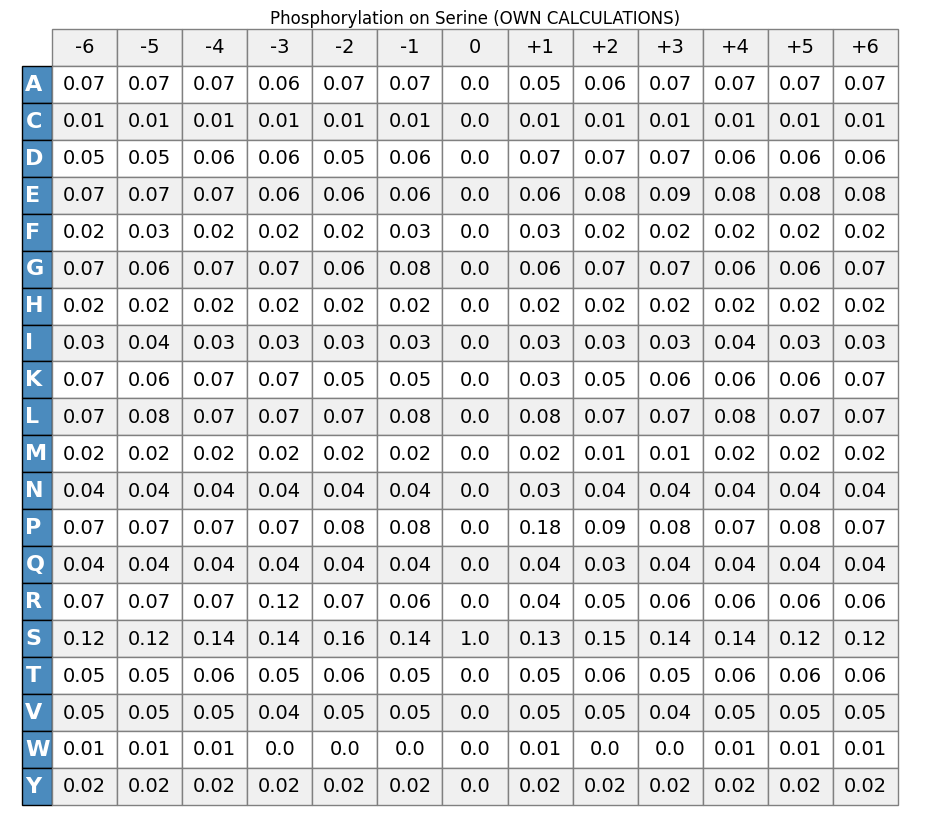

In [263]:
with open(r'rawDatasetTables\untouched_correct\Phosphorylation\freq\S.json', 'r') as f:
    content = json.load(f)
    df = pd.DataFrame(content)
    df = df.round(2)
    df = df.drop(columns=['-10', '-9', '-8', '-7', '+7', '+8', '+9', '+10'])

_, ax = plt.subplots(figsize=(12, 10))

ax.set_title('Phosphorylation on Serine (OWN CALCULATIONS)')
ax.set_axis_off()

header_color = '#4B8BBE'
row_colors = ['#f0f0f0', '#ffffff']

table = ax.table(
    cellText=df.round(2).values,
    colLabels=df.columns,
    rowLabels=df.index,
    loc='center',
    cellLoc='center',
    colColours=[header_color] * len(df.columns),
    rowColours=row_colors * (len(df) // 2 + 1)
)

table.auto_set_font_size(False)
table.set_fontsize(14)

for (i, j), cell in table.get_celld().items():
    if i == -1 or j == -1:
        cell.set_fontsize(16)
        cell.set_text_props(weight='bold', color='white')
        cell.set_edgecolor('black')
        cell.set_facecolor(header_color)
    else:
        cell.set_edgecolor('gray')
        if i % 2 == 0:
            cell.set_facecolor(row_colors[0])
        else:
            cell.set_facecolor(row_colors[1])
    cell.set_height(0.048)
    cell.set_width(0.07)

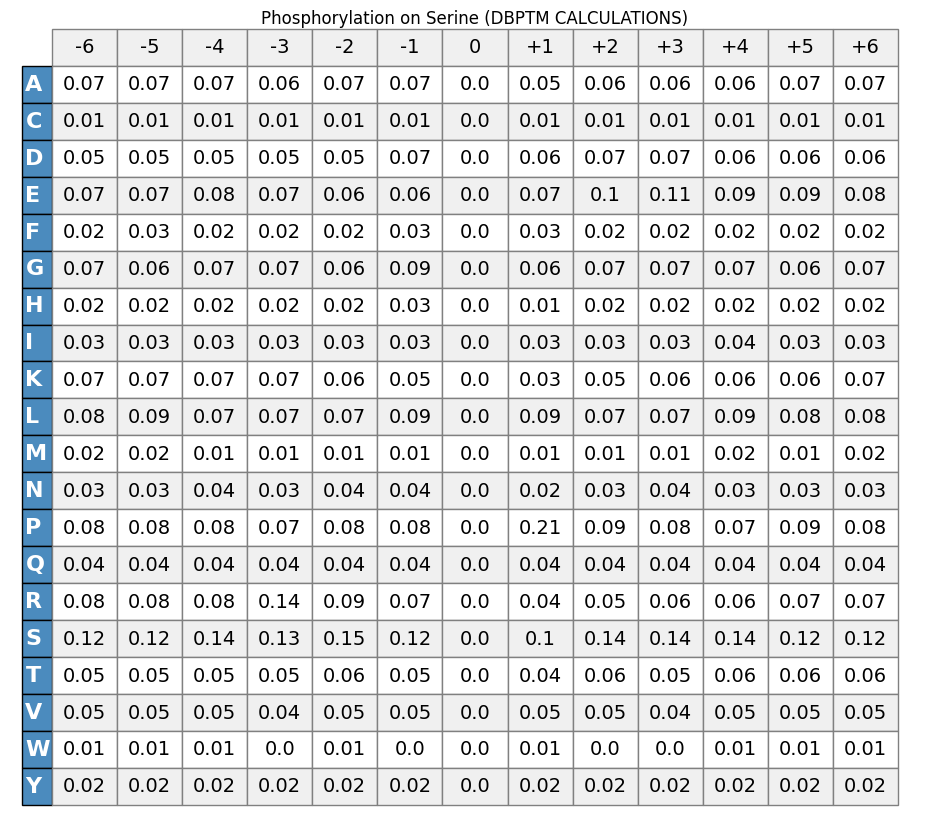

In [268]:
dbptm_df = pd.read_csv(
    'test_file.tsv',
    sep='\t'
)
dbptm_df = dbptm_df.set_index('AminoAcid')
dbptm_df = dbptm_df.sort_index()

_, ax = plt.subplots(figsize=(12, 10))

ax.set_title('Phosphorylation on Serine (DBPTM CALCULATIONS)')
ax.set_axis_off()

header_color = '#4B8BBE'
row_colors = ['#f0f0f0', '#ffffff']

table = ax.table(
    cellText=dbptm_df.round(2).values,
    colLabels=dbptm_df.columns,
    rowLabels=dbptm_df.index,
    loc='center',
    cellLoc='center',
    colColours=[header_color] * len(dbptm_df.columns),
    rowColours=row_colors * (len(dbptm_df) // 2 + 1)
)

table.auto_set_font_size(False)
table.set_fontsize(14)

for (i, j), cell in table.get_celld().items():
    if i == -1 or j == -1:
        cell.set_fontsize(16)
        cell.set_text_props(weight='bold', color='white')
        cell.set_edgecolor('black')
        cell.set_facecolor(header_color)
    else:
        cell.set_edgecolor('gray')
        if i % 2 == 0:
            cell.set_facecolor(row_colors[0])
        else:
            cell.set_facecolor(row_colors[1])
    cell.set_height(0.048)
    cell.set_width(0.07)

POS -6
	L -  -0.01
	N -  0.01
	P -  -0.01
	R -  -0.01
POS -5
	I -  0.01
	K -  -0.01
	L -  -0.01
	N -  0.01
	P -  -0.01
	R -  -0.01
POS -4
	D -  0.01
	E -  -0.01
	M -  0.01
	P -  -0.01
	R -  -0.01
	T -  0.01
POS -3
	D -  0.01
	E -  -0.01
	M -  0.01
	N -  0.01
	R -  -0.02
	S -  0.01
POS -2
	K -  -0.01
	M -  0.01
	R -  -0.02
	S -  0.01
	W -  -0.01
POS -1
	D -  -0.01
	G -  -0.01
	H -  -0.01
	L -  -0.01
	M -  0.01
	R -  -0.01
	S -  0.02
POS 0
	S -  1.0
POS +1
	D -  0.01
	E -  -0.01
	H -  0.01
	L -  -0.01
	M -  0.01
	N -  0.01
	P -  -0.03
	S -  0.03
	T -  0.01
POS +2
	E -  -0.02
	N -  0.01
	Q -  -0.01
	S -  0.01
POS +3
	A -  0.01
	E -  -0.02
POS +4
	A -  0.01
	E -  -0.01
	G -  -0.01
	L -  -0.01
	N -  0.01
POS +5
	E -  -0.01
	L -  -0.01
	M -  0.01
	N -  0.01
	P -  -0.01
	R -  -0.01
POS +6
	L -  -0.01
	N -  0.01
	P -  -0.01
	R -  -0.01


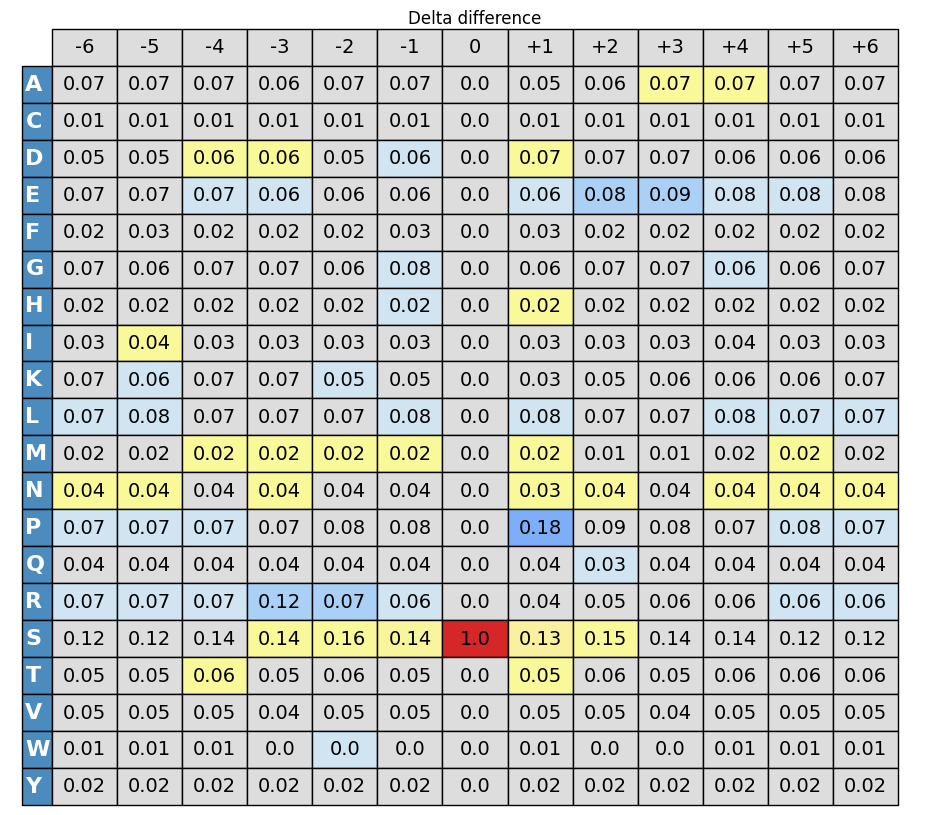

In [267]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

color_dict = {
    1.0: "#d62728",     # Bright red (high positive value)
    0.5: "#f2a8c2",     # Light pinkish red
    0.1: "#f6c2b7",     # Lighter pink
    0.075: "#f8d0ab",   # Creamy color
    0.05: "#f9db9e",    # Very light cream
    0.04: "#f9e59a",    # Light yellowish
    0.03: "#f9f19d",    # Pale yellow
    0.02: "#f9f59d",    # Lightest yellow
    0.01: "#f9f99a",    # Pale yellow-green
    0.0: "#ffffff",     # White (neutral or zero)
    -0.01: "#d0e4f2",   # Light blue
    -0.02: "#aad0f6",   # Medium light blue
    -0.03: "#7eaef7",   # Slightly stronger blue
    -0.04: "#569bff",   # Blue (distinct from the others)
    -0.05: "#1a82ff",   # Bright blue
    -0.075: "#0066cc",  # Medium blue
    -0.1: "#004c99",    # Darker blue
    -0.5: "#003f5c",    # Deep blue
    -1.0: "#012a54"     # Deep blue (same for -1.0 and -0.5 for clarity)
}

with open(r'rawDatasetTables\untouched_correct\Phosphorylation\freq\S.json', 'r') as f:
    content = json.load(f)
    df = pd.DataFrame(content)
    df = df.round(2)
    df = df.drop(columns=['-10', '-9', '-8', '-7', '+7', '+8', '+9', '+10'])

_, ax = plt.subplots(figsize=(12, 10))

ax.set_title('Delta difference')
ax.set_axis_off()

header_color = '#4B8BBE'
row_colors = ['#f0f0f0', '#ffffff']

color_keys = list(color_dict.keys())

for i, key in enumerate(own.keys()):
    print(f"POS {key}")
    for j, aa in enumerate(own[key].keys()):
        if own[key][aa] != dbptm[key][aa]:
            value = round(float(own[key][aa]) - float(dbptm[key][aa]), 2)
            print(f"\t{aa} - ", value)
            closest_value = min(color_keys, key=lambda x: abs(x - value))
            df.at[aa, key] = str(df.at[aa, key]) + color_dict[closest_value]

table = ax.table(
    cellText=df.round(2).values,
    colLabels=df.columns,
    rowLabels=df.index,
    loc='center',
    cellLoc='center',
    colColours=[header_color] * len(df.columns),
    rowColours=row_colors * (len(df) // 2 + 1)
)

table.auto_set_font_size(False)
table.set_fontsize(14)


for (i, j), cell in table.get_celld().items():
    if i == -1 or j == -1:
        cell.set_fontsize(16)
        cell.set_text_props(weight='bold', color='white')
        cell.set_edgecolor('black')
        cell.set_facecolor(header_color)
    else:
        if '#' in cell.get_text().get_text():
            text = cell.get_text().get_text()
            color = text[text.find('#'):]
            actual_text = text[:text.find('#')]
            cell.get_text().set_text(actual_text)
            cell.set_facecolor(color)
        else:
            # print((i, j))
            # cell.set_edgecolor('gray')
            # if i % 2 == 0:
            #     cell.set_facecolor(row_colors[0])
            # else:
            cell.set_facecolor('#dddddd')
    cell.set_height(0.048)
    cell.set_width(0.07)
        # print(f"\t{aa}\t{own[key][aa]}\t{dbptm[key][aa]}")

In [33]:
from glob import glob
filenames = [i.split('\\')[-1] for i in glob('rawDataset/*')]
filenames.remove('zips')


float

For Phosphorylation.csv
	Read


In [5]:
import pandas as pd

AA = "A C D E F G H I K L M N P Q R S T V W Y".split(' ')

def get_middle_characters(strings):
    return ''.join(s[len(s) // 2] for s in strings if s)

df = pd.read_csv(
    'rawDataset/Phosphorylation',
    names=[
        'ProID',
        'Acc#',
        'ModSite',
        'PTM',
        'EvdId',
        'Seq'
    ],
    header=None,
    sep='\t'
)
df = df.dropna(how='any')

answer = get_middle_characters(df.Seq.to_list())

In [18]:
df = df[(df.Seq.str[10] == 'S') | (df.Seq.str[10] == 'T') | (df.Seq.str[10] == 'Y')]
sequences = df.Seq.to_list()
transposed = list(map(''.join, zip(*sequences)))
pos = [f"+{i}" if i > 0 else f"{i}" for i in range(-10, 11)]
table = {i: seq for i, seq in zip(pos, transposed)}

def log_odds(sequences: dict, method: typing.Literal['freq', 'log-e', 'log10', 'log2'] = 'freq') -> dict[dict[str, float]]:
    table = dict.fromkeys(sequences, 0)

    for position, sequence in sequences.items():
        log_odds_table = dict.fromkeys(AA, 0)
        for aa in AA:
            total = len(sequence)
            count = sequence.count(aa)
            log_odds_table[aa] = count / total # For now, let's keep it simple count_a / count
            if method == 'log-e':
                log_odds_table[aa] = round(np.log(log_odds_table[aa]), 3)
            elif method == 'log10':
                log_odds_table[aa] = np.log10(log_odds_table[aa])
            elif method == 'log2':
                log_odds_table[aa] = np.log2(log_odds_table[aa])
            
            if log_odds_table[aa] == float('-inf'):
                log_odds_table[aa] = '-inf'

        table[position] = log_odds_table

    return table

table = log_odds(table, 'log-e')

print("\tCalculated")
with open(f'./rawDatasetTables/untouched/Phosphorylation_adjusted.json', 'w') as f:
    json.dump(table, f)

table_df = pd.DataFrame(table)

C:\Users\Abdullah Faiz\AppData\Local\Temp\ipykernel_5248\3902419659.py:17: RuntimeWarning: divide by zero encountered in log
  log_odds_table[aa] = round(np.log(log_odds_table[aa]), 3)


	Calculated


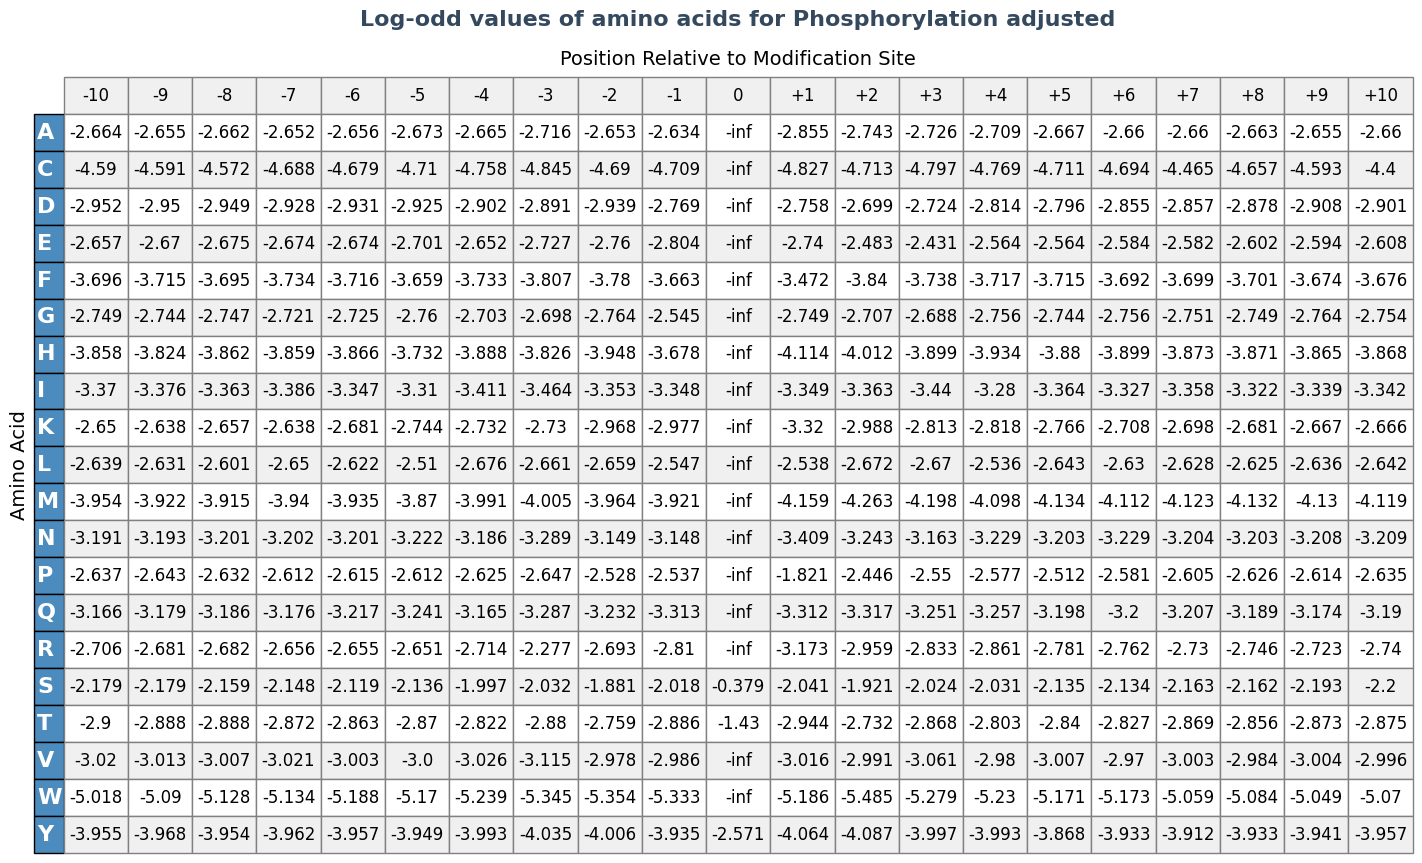

In [19]:
_, ax = plt.subplots(figsize=(14, 6))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_frame_on(False)

header_color = '#4B8BBE'
row_colors = ['#f0f0f0', '#ffffff']

table = ax.table(
    cellText=table_df.values,
    colLabels=table_df.columns,
    rowLabels=table_df.index,
    loc='center',
    cellLoc='center',
    colColours=[header_color] * len(table_df.columns),
    rowColours=row_colors * (len(table_df) // 2 + 1)
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(table_df.columns))))

for (i, j), cell in table.get_celld().items():
    if i == -1 or j == -1:
        cell.set_fontsize(16)
        cell.set_text_props(weight='bold', color='white')
        cell.set_edgecolor('black')
        cell.set_facecolor(header_color)
    else:
        cell.set_edgecolor('gray')
        if i % 2 == 0:
            cell.set_facecolor(row_colors[0])
        else:
            cell.set_facecolor(row_colors[1])
    cell.set_height(0.08)


ax.set_title(
    f'Log-odd values of amino acids for Phosphorylation adjusted',
    pad=150,
    fontsize=16,
    weight='bold',
    color='#34495E'
)
ax.set_xlabel("Position Relative to Modification Site", labelpad=-465, fontsize=14)
ax.set_ylabel("Amino Acid", labelpad=120, fontsize=14)

plt.show()

In [2]:
import pandas as pd
data = pd.read_csv(
    'rawDataset/Phosphorylation',
    names=[
        'ProID',
        'Acc#',
        'ModSite',
        'PTM',
        'EvdId',
        'Seq'
    ],
    header=None,
    sep='\t'
)

print(len(data))
data = data.dropna(how='any')
print(len(data))
data.isnull().sum()

1615054
1614944


ProID      0
Acc#       0
ModSite    0
PTM        0
EvdId      0
Seq        0
dtype: int64

In [13]:
import numpy as np
AA = "A C D E F G H I K L M N P Q R S T V W Y".split(' ')

def normal_print():
    for aa in AA:
        print(
            aa,
            len(
                data[data['Seq'].str[10] == aa]
            )
        )
def numpy_print():
    for aa in AA:
        print(
            aa,
            len(
                data[np.array([seq[10] for seq in data['Seq']]) == aa]
            )
        )

#normal_print()
numpy_print()

A 113
C 36
D 664
E 137
F 39
G 110
H 468
I 57
K 120
L 123
M 17
N 56
P 162
Q 66
R 828
S 1102904
T 385695
V 92
W 12
Y 123245


In [18]:
data['Seq'].to_numpy()

NameError: name 'data' is not defined